<a href="https://colab.research.google.com/github/UTakeuchi/PDsimulator/blob/main/main_case2_dqn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install dezero # 初回のみ

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import copy
from collections import deque, defaultdict
import random
import numpy as np
import matplotlib.pyplot as plt
from dezero import Model
from dezero import optimizers
import dezero.functions as F
import dezero.layers as L

# DQNエージェント

In [4]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.buffer = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        self.buffer.append(data)

    def __len__(self):
        return len(self.buffer)

    def get_batch(self):
        data = random.sample(self.buffer, self.batch_size)

        state = np.stack([x[0] for x in data])
        action = np.array([x[1] for x in data])
        reward = np.array([x[2] for x in data])
        next_state = np.stack([x[3] for x in data])
        done = np.array([x[4] for x in data]).astype(np.int32)
        return state, action, reward, next_state, done

class QNet(Model):
    def __init__(self, action_size):
        super().__init__()
        self.l1 = L.Linear(128)
        self.l2 = L.Linear(128)
        self.l3 = L.Linear(action_size)

    def forward(self, x):
        # x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x


class DQNAgent:
    def __init__(self):
        self.gamma = 0.98
        self.lr = 0.0005
        self.epsilon = 0.1
        self.buffer_size = 10000
        self.batch_size = 32
        self.action_size = 2

        self.replay_buffer = ReplayBuffer(self.buffer_size, self.batch_size)
        self.qnet = QNet(self.action_size)
        self.qnet_target = QNet(self.action_size)
        self.optimizer = optimizers.Adam(self.lr)
        self.optimizer.setup(self.qnet)

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            state = state[np.newaxis, :]
            qs = self.qnet(state)
            return qs.data.argmax()

    def update(self, state, action, reward, next_state, done=False):
        self.replay_buffer.add(state, action, reward, next_state, done)
        if len(self.replay_buffer) < self.batch_size:
            return

        state, action, reward, next_state, done = self.replay_buffer.get_batch()
        qs = self.qnet(state)
        q = qs[np.arange(self.batch_size), action]

        next_qs = self.qnet_target(next_state)
        next_q = next_qs.max(axis=1)
        next_q.unchain()
        target = reward + (1 - done) * self.gamma * next_q

        loss = F.mean_squared_error(q, target)

        self.qnet.cleargrads()
        loss.backward()
        self.optimizer.update()

    def sync_qnet(self):
        self.qnet_target = copy.deepcopy(self.qnet)

# Prisoner's dillema game

In [5]:
class PDGame:
    def __init__(self):
        self.action_space = [0, 1]
        self.action_meaning = {
            0: "Defect",
            1: "Cooperate",
        }
        self.b = 2 #benefit
        self.c = 1 #cost
    
    def matching(self, agents):
        pairs = len(agents) // 2
        return np.random.choice(agents, size=(pairs, 2), replace=False) # agentの番号を返す
        
    def step(self, a1, a2):
        u1 = {(1, 1):self.b - self.c, (1, 0):-self.c, (0, 1):self.b, (0, 0):0}
        u2 = {(1, 1):self.b - self.c, (1, 0):self.b, (0, 1):-self.c, (0, 0):0}
        return u1[(a1,a2)], u2[(a1,a2)]

# シミュレーションの実行

## 所得を状態とするもの

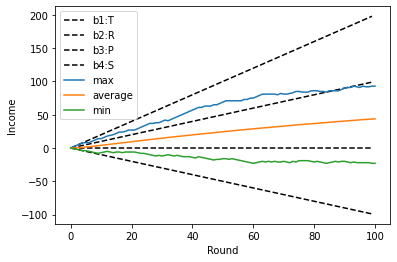

In [6]:
env = PDGame()
n = 100 # agentの人数 n
agents = []
for i in range(n):
    agents.append(DQNAgent())
incomes = np.zeros(n) # 所得はAgents()の外部に格納
income_history = np.zeros((3,1)) # 各行に平均値・最大値・最小値の推移を格納

R = {'g', 'b'}
rep = np.full(n, 'g') # 評判を格納する配列
def norm9(rep_i, rep_j, a_i):
    if (rep_j == 'g' and a_i == 1) or (rep_j == 'b' and a_i == 0):
        return 'g'
    else:
        return 'b'

rounds = 100
sync_interval = 10
for round in range(rounds):
    players = env.matching(range(len(agents)))
    for pair in players:
        x, y = pair
        player1, player2 = agents[x], agents[y]
        state = np.array([incomes[x], incomes[y]]) #stateは（自分の所得, 相手の所得）の順にする
    
        a1 = player1.get_action(state)
        a2 = player2.get_action(state[::-1]) #player2目線に変換
        r1, r2 = env.step(a1, a2)
        incomes[x] += r1
        incomes[y] += r2
        next_state = np.array([incomes[x], incomes[y]])
        player1.update(state, a1, r1, next_state)
        player2.update(state[::-1], a2, r2, next_state[::-1])
    
    if round % sync_interval == 0:
        for agent in agents:
            agent.sync_qnet()

    add = np.array([[incomes.max()], [np.mean(incomes)], [incomes.min()]])
    income_history = np.append(income_history, add, axis=1)

def plot_total_income(history):
    x = range(0, 100)
    y1 = [(env.b - env.c) * n for n in x] # 全員が協力
    y2 = np.zeros(100) # 全員が非協力
    y3 = [env.b * n for n in x] # 裏切り続ける
    y4 = [- env.c * n for n in x] # 裏切られ続ける
    plt.xlabel('Round')
    plt.ylabel('Income')
    plt.plot(x, y3, ls='--', label='b1:T', color='black')
    plt.plot(x, y1, ls='--', label='b2:R', color='black')
    plt.plot(x, y2, ls='--', label='b3:P', color='black')
    plt.plot(x, y4, ls='--', label='b4:S', color='black')
    plt.plot(range(len(history[0])), history[0], label='max')
    plt.plot(range(len(history[1])), history[1], label='average')
    plt.plot(range(len(history[2])), history[2], label='min')
    plt.legend()
    plt.show()

plot_total_income(income_history)

## 3. 学習後のテストフェーズ

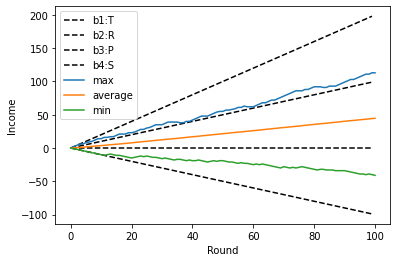

In [7]:
incomes = np.zeros(n) # 所得を初期化
income_history = np.zeros((3,1)) # 各行に平均値・最大値・最小値の推移を格納

rounds = 100
sync_interval = 20
for round in range(rounds):
    players = env.matching(range(len(agents))) # agentは変わらず
    for pair in players:
        x, y = pair
        player1, player2 = agents[x], agents[y]
        state = np.array([incomes[x], incomes[y]]) #stateは（自分の所得, 相手の所得）の順にする
    
        a1 = player1.get_action(state)
        a2 = player2.get_action(state[::-1]) #player2目線に変換
        r1, r2 = env.step(a1, a2)
        incomes[x] += r1
        incomes[y] += r2
        # next_state = np.array([incomes[x], incomes[y]]) #ここは学習させない
        # player1.update(state, a1, r1, next_state)
        # player2.update(state[::-1], a2, r2, next_state[::-1])

    add = np.array([[incomes.max()], [np.mean(incomes)], [incomes.min()]])
    income_history = np.append(income_history, add, axis=1)

plot_total_income(income_history)

## 4. 既存の研究（評判を状態とするモデル）
---



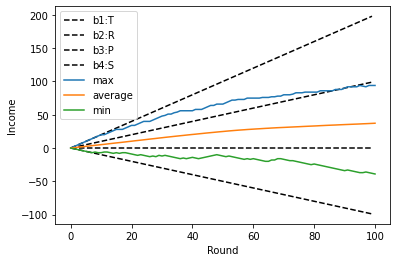

In [8]:
env = PDGame()
n = 100 # agentの人数 n
agents_ = [] # 別のエージェントたち
for i in range(n):
    agents_.append(DQNAgent())
incomes = np.zeros(n) # 所得はAgents()の外部に格納
income_history = np.zeros((3,1)) # 各行に平均値・最大値・最小値の推移を格納

R = {0, 1} # 0: bad, 1: good
rep = np.ones(n) # 評判を格納する配列
def norm9(rep_i, rep_j, a_i):
    if (rep_j == 1 and a_i == 1) or (rep_j == 0 and a_i == 0):
        return 1
    else:
        return 0

rounds = 100
sync_interval = 10
for round in range(rounds):
    players = env.matching(range(len(agents_)))
    for pair in players:
        x, y = pair
        player1, player2 = agents_[x], agents_[y]
        state = np.array([rep[x], rep[y]]) #stateは（自分の所得, 相手の所得）の順にする
    
        a1 = player1.get_action(state)
        a2 = player2.get_action(state[::-1]) #player2目線に変換
        r1, r2 = env.step(a1, a2)
        incomes[x] += r1
        incomes[y] += r2
        next_state = np.array([norm9(state[0], state[1], a1), norm9(state[1], state[0], a2)])
        player1.update(state, a1, r1, next_state)
        player2.update(state[::-1], a2, r2, next_state[::-1])
    
    if round % sync_interval == 0:
        for agent in agents_:
            agent.sync_qnet()

    add = np.array([[incomes.max()], [np.mean(incomes)], [incomes.min()]])
    income_history = np.append(income_history, add, axis=1)

plot_total_income(income_history)

## 5. 初期値を最初から偏らせたとき

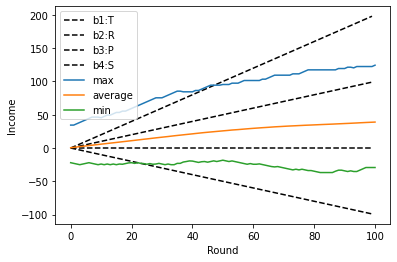

In [9]:
env = PDGame()
n = 100 # agentの人数 n
agents_ = [] # 別のエージェントたち
for i in range(n):
    agents_.append(DQNAgent())
incomes = np.random.normal(0, 10, n) # 所得の初期値を正規分布からランダムに
income_history = np.array([[incomes.max()], [np.mean(incomes)], [incomes.min()]]) # 各行に平均値・最大値・最小値の推移を格納

R = {0, 1} # 0: bad, 1: good
rep = np.ones(n) # 評判を格納する配列
def norm9(rep_i, rep_j, a_i):
    if (rep_j == 1 and a_i == 1) or (rep_j == 0 and a_i == 0):
        return 1
    else:
        return 0

rounds = 100
sync_interval = 10
for round in range(rounds):
    players = env.matching(range(len(agents_)))
    for pair in players:
        x, y = pair
        player1, player2 = agents_[x], agents_[y]
        state = np.array([rep[x], rep[y]]) #stateは（自分の所得, 相手の所得）の順にする
    
        a1 = player1.get_action(state)
        a2 = player2.get_action(state[::-1]) #player2目線に変換
        r1, r2 = env.step(a1, a2)
        incomes[x] += r1
        incomes[y] += r2
        next_state = np.array([norm9(state[0], state[1], a1), norm9(state[1], state[0], a2)])
        player1.update(state, a1, r1, next_state)
        player2.update(state[::-1], a2, r2, next_state[::-1])
    
    if round % sync_interval == 0:
        for agent in agents_:
            agent.sync_qnet()

    add = np.array([[incomes.max()], [np.mean(incomes)], [incomes.min()]])
    income_history = np.append(income_history, add, axis=1)

plot_total_income(income_history)

## 6. 所得の変化の幅（エージェント内での順位の変化）

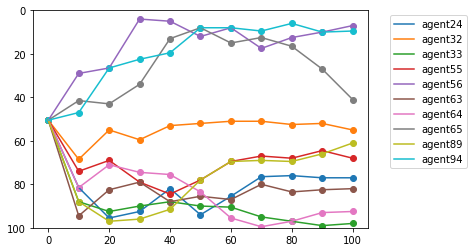

In [43]:
env = PDGame()
n = 100 # agentの人数 n
agents_ = [] # 別のエージェントたち
for i in range(n):
    agents_.append(DQNAgent())
incomes = np.zeros((n,1)) # 所得はAgents()の外部に格納
income_history = np.zeros((n,1)) # 全員分の所得を格納

R = {0, 1} # 0: bad, 1: good
rep = np.ones(n) # 評判を格納する配列
def norm9(rep_i, rep_j, a_i):
    if (rep_j == 1 and a_i == 1) or (rep_j == 0 and a_i == 0):
        return 1
    else:
        return 0

rounds = 100
sync_interval = 10
for round in range(1, rounds+1):
    players = env.matching(range(len(agents_)))
    for pair in players:
        x, y = pair
        player1, player2 = agents_[x], agents_[y]
        state = np.array([rep[x], rep[y]]) #stateは（自分の所得, 相手の所得）の順にする
    
        a1 = player1.get_action(state)
        a2 = player2.get_action(state[::-1]) #player2目線に変換
        r1, r2 = env.step(a1, a2)
        incomes[x] += r1
        incomes[y] += r2
        next_state = np.array([norm9(state[0], state[1], a1), norm9(state[1], state[0], a2)])
        player1.update(state, a1, r1, next_state)
        player2.update(state[::-1], a2, r2, next_state[::-1])

    if round % sync_interval == 0:
        for agent in agents_:
            agent.sync_qnet()
        income_history = np.append(income_history, incomes, axis=1)

from scipy.stats import rankdata

def plot_income_rank(history, num):
    rank = rankdata(-history.T, axis=1).T
    nums = np.random.randint(0, 100, num)
    plt.ylim(100, 0)
    for i in range(len(history)):
        if i in nums:
            plt.scatter([0,10,20,30,40,50,60,70,80,90,100], rank[i])
            plt.plot([0,10,20,30,40,50,60,70,80,90,100], rank[i], label='agent{}'.format(i))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

plot_income_rank(income_history, 10)

## 7. マッチングパターンの変化

## 8. 累計で何割努力したか

## 9. 偏差（50回時点、100回時点など）

# QNet, 方策のチェック

In [20]:
c = 0
for i in range(10):
    for j in range(10):
        var = agents_[50].qnet(np.array([i,j]))
        print(var)
        if (var[1] - var[0]).data > 0:
            c += 1
print(c, c / 100)

variable([0.00521083 0.01149664])
variable([0.56688342 0.67673856])
variable([1.12658953 1.337115  ])
variable([1.68629564 1.99749143])
variable([2.24600174 2.65786786])
variable([2.80570785 3.3182443 ])
variable([3.36541396 3.97862073])
variable([3.92512007 4.63899716])
variable([4.48482618 5.2993736 ])
variable([5.04453228 5.95975003])
variable([0.28452348 0.38835908])
variable([0.82890764 0.95721658])
variable([1.64130254 1.7029008 ])
variable([2.27742696 2.51677586])
variable([2.85922892 3.23429626])
variable([3.44044801 3.9333068 ])
variable([4.01238319 4.62492952])
variable([4.57937318 5.31278262])
variable([5.13408795 5.9952521 ])
variable([5.67503469 6.66820085])
variable([0.56128032 0.76268436])
variable([1.01381266 1.23550633])
variable([1.64709451 1.89563691])
variable([2.53040317 2.67173589])
variable([3.27149259 3.3862965 ])
variable([3.91200041 4.21779603])
variable([4.54417494 5.01458941])
variable([5.12666867 5.7440297 ])
variable([5.70854844 6.44992719])
variable([6.29

In [39]:
c = 0
for i in range(2):
    for j in range(2):
        var = agents_[99].qnet(np.array([i,j]))
        print(i, j, var)
        if (var[1] - var[0]).data > 0:
            c += 1
print(c, c / 4)

0 0 variable([0.05867683 0.05801864])
0 1 variable([1.2252259  0.31028572])
1 0 variable([0.14459165 0.55203776])
1 1 variable([1.10980748 0.59997809])
1 0.25
